In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show pandas

Name: pandas
Version: 2.2.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u

In [3]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [5]:
news = pd.read_parquet("/workspaces/fyp/crypto_news/data/3b.cryptonews_absa.parquet")
news

,title,text,source_name,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa
index,,,,,,,,,,
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,0.0,0.5,0.0,0.0,0.7,0.0
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,0.0,0.3,0.0,0.5,0.7,0.0
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00,0.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
159481,XRP News Today: BTC Hits $91k; Will SEC Appeal...,"XRP price drops below $2, weighed by SEC appea...",FXEmpire,2024-12-31 05:34:31+00:00,0.0,0.0,0.0,0.0,0.0,0.0
159482,Tether Moves Bitcoin Worth $780M to Reserve in...,"Tether, the issuer of the world's most widely ...",Cryptonews,2024-12-31 05:28:54+00:00,0.0,0.0,0.0,0.0,0.0,0.0
159483,The Bull Run Continues; Bitfinex Projects $200...,Digital asset exchange Bitfinex predicted an u...,Zycrypto,2024-12-31 05:21:59+00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def news_handling_hour(path):
    news = pd.read_parquet(path)

    news["date"] = pd.to_datetime(news["date"])
    news_absa = news[["date","tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa"]]
    news_absa["date_hour"] = news_absa['date'].dt.floor('H')

    entries_per_hour = news_absa.groupby('date_hour').size()

    all_hours = pd.date_range(start=news_absa["date_hour"].min(),end= news_absa["date_hour"].max(), freq="H")

    entries_per_hour = entries_per_hour.reindex(all_hours, fill_value=0)

    news_absa['entries_per_hour'] = news_absa['date_hour'].map(entries_per_hour)
    # news_absa['entries_per_hour'] = news_absa['entries_per_hour'].fillna(0) 

    # grouped_news_by_hour = news.groupby('date_hour').size()
    sentiment_columns = [
    'tanalysis_absa',
    'economy_absa',
    'regulation_absa',
    'technology_absa',
    'adoption_absa'
    ]

    # 2. Compute the average sentiment for each entry (row) by averaging across the sentiment columns
    news_absa['Average Sentiment'] = news_absa[sentiment_columns].mean(axis=1)
    news_absa['Average Sentiment'].fillna(0, inplace=True)
    news_absa['Sentiment_6HR'] = news_absa['Average Sentiment'].rolling(window=6, min_periods=1).mean()
    news_absa['Sentiment_12HR'] = news_absa['Average Sentiment'].rolling(window=12, min_periods=1).mean()
    news_absa['Sentiment_24HR'] = news_absa['Average Sentiment'].rolling(window=24, min_periods=1).mean()

    return news_absa


In [7]:
def MutualInfo(df):
  X = df.drop(["target","date"], axis=1)
  y = df["target"]
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores.sort_values(ascending=False, inplace=True)
  print(mi_scores)

In [8]:
def filling_empty_news(df):
# Create a complete range of hours
    df = df.sort_values('date_hour').reset_index(drop=True)

    start_time = pd.to_datetime("2021-01-01 10:00:00+00:00")
    end_time = df['date_hour'].max()
    full_hours = pd.date_range(start=start_time, end=end_time, freq='H')

    # Create a complete DataFrame with all hours
    full_df = pd.DataFrame({'date_hour': full_hours})

    # Merge with original data
    merged_df = pd.merge(full_df, df, on='date_hour', how='left')

    # Function to fill missing values with mean of previous 3 entries
    def fill_with_previous_mean(df, column):
        for i in range(len(df)):
            if pd.isna(df.loc[i, column]):
                # Get previous 3 entries or as many as available
                start_idx = max(0, i-3)
                previous_values = df.loc[start_idx:i-1, column].dropna()
                
                if len(previous_values) > 0:
                    df.loc[i, column] = previous_values.mean()
        return df

    def fill_with_previous_value(df, column):
        for i in range(len(df)):
            if pd.isna(df.loc[i, column]):
                # Get previous 3 entries or as many as available
                start_idx = max(0, i)
                previous_values = df.loc[start_idx:i-1, column].dropna()
                
                if len(previous_values) > 0:
                    df.loc[i, column] = previous_values.mean()
        return df

    def fill_with_previous_value(df, column):
        # Create a copy of the dataframe to avoid modifying the original
        df_filled = df.copy()
        
        # Iterate through each row
        for i in range(1, len(df_filled)):  # Start from index 1 (second row)
            # Check if the current value is missing
            if pd.isna(df_filled.loc[i, column]):
                # Fill with the previous value
                df_filled.loc[i, column] = df_filled.loc[i-1, column]
        
        # Special case for the first row if it's missing
        if pd.isna(df_filled.loc[0, column]) and len(df_filled) > 1:
            # If the first row is missing, use the next available value
            for j in range(1, len(df_filled)):
                if not pd.isna(df_filled.loc[j, column]):
                    df_filled.loc[0, column] = df_filled.loc[j, column]
                    break
        
        return df_filled
    def fill_with_zero(df, column):
        # Create a copy of the dataframe to avoid modifying the original
        df_filled = df.copy()
        
        # Replace NaN values with 0 in the specified column
        df_filled[column] = df_filled[column].fillna(0)
        
        return df_filled
    
    # Fill missing values for each column
    columns_to_fill = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 
                    'technology_absa', 'adoption_absa']
    
    for col in columns_to_fill:
        merged_df = fill_with_previous_mean(merged_df, col)
    
    col_filled_by_prev_value = ["Sentiment_6HR","Sentiment_12HR", "Sentiment_24HR", "Average Sentiment"]
    for col in col_filled_by_prev_value:
        merged_df = fill_with_previous_value(merged_df,col)    
    
    col_filled_by_zero = ["entries_per_hour"]
    for col in col_filled_by_zero:
        merged_df = fill_with_zero(merged_df,col)
    return merged_df


In [9]:
news_by_hour = news_handling_hour("/workspaces/fyp/crypto_news/data/3b.cryptonews_absa.parquet")

# Display the filtered data
news_by_hour = news_by_hour.groupby([news_by_hour['date_hour']], as_index=False).mean()

news_by_hour = news_by_hour.drop(['date'], axis=1)
news_by_hour = news_by_hour[:-5]
news_by_hour


,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR
0,2021-01-01 06:00:00+00:00,0.850000,0.0,0.0,0.0,0.15,2.0,0.200000,0.143333,0.170833,0.194583
1,2021-01-01 08:00:00+00:00,0.400000,0.0,0.0,0.0,0.50,2.0,0.180000,0.163333,0.179167,0.192500
2,2021-01-01 09:00:00+00:00,-0.050000,0.0,0.0,0.0,0.40,2.0,0.070000,0.193333,0.191667,0.193750
3,2021-01-01 10:00:00+00:00,0.766667,0.0,0.0,0.0,0.30,3.0,0.213333,0.198889,0.216667,0.177500
4,2021-01-01 11:00:00+00:00,1.000000,0.0,0.0,0.0,0.00,2.0,0.200000,0.190000,0.202500,0.179167
...,...,...,...,...,...,...,...,...,...,...,...
32090,2024-12-31 19:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,6.0,0.000000,0.000000,0.000000,0.000000
32091,2024-12-31 20:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,6.0,0.000000,0.000000,0.000000,0.000000
32092,2024-12-31 21:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,3.0,0.000000,0.000000,0.000000,0.000000
32093,2024-12-31 22:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,4.0,0.000000,0.000000,0.000000,0.000000


In [10]:
news_by_hour_filled = filling_empty_news(news_by_hour)
news_by_hour_filled

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR
0,2021-01-01 10:00:00+00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,0.177500
1,2021-01-01 11:00:00+00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,0.179167
2,2021-01-01 12:00:00+00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,0.175471
3,2021-01-01 13:00:00+00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,0.172581
4,2021-01-01 14:00:00+00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,0.155110
...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000
35050,2024-12-31 20:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000
35051,2024-12-31 21:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,0.000000
35052,2024-12-31 22:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,0.000000


In [11]:
news_by_hour_filled.to_parquet('/workspaces/fyp/crypto_news/data/6.News_by_hour_filled.parquet')  
news_by_hour.to_parquet('/workspaces/fyp/crypto_news/data/6.News_by_hour.parquet')  


In [12]:
# Simple version
print("Missing values by column:")
print(news_by_hour.isna().sum())
print("\nTotal missing values:", news_by_hour.isna().sum().sum())


Missing values by column:
date_hour            0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_hour     0
Average Sentiment    0
Sentiment_6HR        0
Sentiment_12HR       0
Sentiment_24HR       0
dtype: int64

Total missing values: 0


In [13]:
def generate_signals(df):
  df['date'] = pd.to_datetime(df['date'])

  # Generate signal column
  # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
  df['signal'] = df['Predicted Return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
  return df

In [14]:
btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")
btc_price.index = pd.to_datetime(btc_price.index)

btc_price

,open,high,low,close,volume,return_forward
timestamp,,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 12:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 13:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 14:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
...,...,...,...,...,...,...
2025-01-06 19:00:00,101805.00,102089.00,101665.00,101853.00,129.918554,0.00278833220425515200
2025-01-06 20:00:00,101892.00,102360.00,101892.00,102137.00,190.003279,-0.00473873327001967945
2025-01-06 21:00:00,102185.00,102407.00,101633.00,101653.00,48.243388,0.00378739437104659970


In [15]:
btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")
data = pd.read_parquet("/workspaces/fyp/crypto_news/data/6.News_by_hour_filled.parquet")

data['date_hour'] = data['date_hour'].dt.tz_localize(None)

btc_price.index = pd.to_datetime(btc_price.index)


# Map btc_price["return_forward_1d"] to data["date"] to create the target column
data["target"] = data["date_hour"].map(btc_price["return_forward"])

# data["target"] = data["target"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
# Optional: Fill missing values in target with 0

data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,0.177500,0.00011763861008622260
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,0.179167,-0.00247456535252905630
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,0.175471,-0.00328966649836125220
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,0.172581,0.00706464171240691160
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,0.155110,0.00121368921223582020
...,...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641
35050,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110
35051,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572
35052,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,0.000000,0.00093253585439578110


In [16]:
data.to_parquet('/workspaces/fyp/crypto_news/data/7.News_by_hour_filled_return.parquet')  

btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")
ndata = pd.read_parquet("/workspaces/fyp/crypto_news/data/6.News_by_hour.parquet")

ndata['date_hour'] = ndata['date_hour'].dt.tz_localize(None)

btc_price.index = pd.to_datetime(btc_price.index)


# Map btc_price["return_forward_1d"] to data["date"] to create the target column
ndata["target"] = ndata["date_hour"].map(btc_price["return_forward"])

# ndata["target"] = ndata["target"].apply(lambda x: 1 if x > 0.001 else (-1 if x < -0.001 else 0))
# Optional: Fill missing values in target with 0

news_by_hour.to_parquet('/workspaces/fyp/crypto_news/data/7.News_by_hour_return.parquet')  


In [ ]:
#Missing Target
target_col = "target"

train_startdate = pd.to_datetime("2021-01-01 10:00:00")
train_enddate = pd.to_datetime("2022-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
train_data = data[(data['date_hour'] >= train_startdate) & (data['date_hour'] <= train_enddate)]

val_startdate = pd.to_datetime("2023-01-01 00:00:00")
val_enddate = pd.to_datetime("2023-12-31 23:00:00")

# Validation: 2023-01-01 to 2023-12-31
validation_data = data[(data['date_hour'] >= val_startdate) & (data['date_hour'] <= val_enddate)]

test_startdate = pd.to_datetime("2024-01-01 00:00:00")
test_enddate = pd.to_datetime("2024-12-31 23:00:00")

# Test: 2024-01-01 to 2024-12-31
test_data = data[(data['date_hour'] >= test_startdate) & (data['date_hour'] <= test_enddate)]

features = ["tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa","cybersecurity_absa","entries_per_day", "Average Sentiment", "Sentiment_6HR", "Sentiment_12HR", "Sentiment_24HR"]
target_col = 'target'

test_data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target
17510,2023-01-01 00:00:00,0.334815,0.121852,-0.005185,0.014815,0.033704,0.0,0.28,0.100000,0.095000,0.070833,-0.00012076565424793189
17511,2023-01-01 01:00:00,0.000000,-0.150000,0.350000,0.000000,0.500000,2.0,0.14,0.091667,0.101667,0.050417,-0.00096624192282142641
17512,2023-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00,0.056667,0.078333,0.046667,-0.00211569848274194523
17513,2023-01-01 03:00:00,0.111605,-0.009383,0.114938,0.004938,0.177901,0.0,0.00,0.056667,0.078333,0.046667,0.00121153380179307000
17514,2023-01-01 04:00:00,0.700000,0.000000,0.000000,0.000000,0.000000,1.0,0.14,0.080000,0.070000,0.055000,-0.00042352371732817038
...,...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,-0.00630797378946472641
35050,2024-12-31 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,0.00285821334903388110
35051,2024-12-31 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.00,0.000000,0.000000,0.000000,-0.00414167075852351572
35052,2024-12-31 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.00,0.000000,0.000000,0.000000,0.00093253585439578110


In [18]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date_hour            0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_hour     0
Average Sentiment    0
Sentiment_6HR        0
Sentiment_12HR       0
Sentiment_24HR       0
target               0
dtype: int64


In [19]:
feature_cols =["tanalysis_absa","economy_absa","regulation_absa", "Sentiment_6HR", "Sentiment_12HR", "Sentiment_24HR"]
target_col = "target"

X_train = train_data[feature_cols]
y_train = train_data[target_col]

# Validation Data
X_val = validation_data[feature_cols]
y_val = validation_data[target_col]

# Test Data
X_test = test_data[feature_cols]
y_test = test_data[target_col]



# RFR

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

X_train_smoothed = X_train.copy()
numeric_columns = X_train_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_train_smoothed[f'{col}_ewm'] = X_train_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()
X_train_smoothed

rf.fit(X_train_smoothed, y_train)


In [ ]:
#Evaluate Model by Validation

X_val_smoothed = X_val.copy()
numeric_columns = X_val_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_val_smoothed[f'{col}_ewm'] = X_val_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_val = rf.predict(X_val_smoothed)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 0.000028
R-squared: -0.3693


In [ ]:
# Example: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],

}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf_reg = grid_search.best_estimator_
best_rf_reg.fit(X_train_smoothed, y_train)


Best Parameters: {'max_depth': 2, 'min_samples_split': 10, 'n_estimators': 200}


RandomForestRegressor(max_depth=2, min_samples_split=10, n_estimators=200,
                      random_state=42)

In [ ]:
importances = best_rf_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


                Feature  Importance
11   Sentiment_24HR_ewm    0.477586
5        Sentiment_24HR    0.108111
4        Sentiment_12HR    0.095518
3         Sentiment_6HR    0.089187
6    tanalysis_absa_ewm    0.087584
9     Sentiment_6HR_ewm    0.050641
10   Sentiment_12HR_ewm    0.049887
0        tanalysis_absa    0.017696
8   regulation_absa_ewm    0.008957
7      economy_absa_ewm    0.006594
1          economy_absa    0.004855
2       regulation_absa    0.003383


In [ ]:
validation_data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target
17510,2023-01-01 00:00:00,0.334815,0.121852,-0.005185,0.014815,0.033704,0.0,0.28,0.100000,0.095000,0.070833,-0.00012076565424793189
17511,2023-01-01 01:00:00,0.000000,-0.150000,0.350000,0.000000,0.500000,2.0,0.14,0.091667,0.101667,0.050417,-0.00096624192282142641
17512,2023-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00,0.056667,0.078333,0.046667,-0.00211569848274194523
17513,2023-01-01 03:00:00,0.111605,-0.009383,0.114938,0.004938,0.177901,0.0,0.00,0.056667,0.078333,0.046667,0.00121153380179307000
17514,2023-01-01 04:00:00,0.700000,0.000000,0.000000,0.000000,0.000000,1.0,0.14,0.080000,0.070000,0.055000,-0.00042352371732817038
...,...,...,...,...,...,...,...,...,...,...,...,...
26265,2023-12-31 19:00:00,0.266667,0.000000,0.066667,0.000000,0.366667,3.0,0.14,0.067778,-0.007778,0.016944,-0.00122350062351474083
26266,2023-12-31 20:00:00,0.000000,0.000000,0.800000,0.000000,1.000000,1.0,0.36,0.086667,-0.026667,-0.001667,0.00296826780371740210
26267,2023-12-31 21:00:00,0.000000,0.000000,-0.500000,0.000000,-0.700000,1.0,-0.24,-0.006667,-0.041667,-0.033333,0.00056371109806224310
26268,2023-12-31 22:00:00,0.088889,0.000000,0.122222,0.000000,0.222222,0.0,-0.24,-0.006667,-0.041667,-0.033333,0.00093898917814972180


Overall Annual Return: 0.0%
Overall Annual Sharpe Ratio: nan
Maximum Drawdown: 0.0 %
Alpha: 0.0
Beta: 0.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023            0.0         0.0          0.0           0.0            NaN


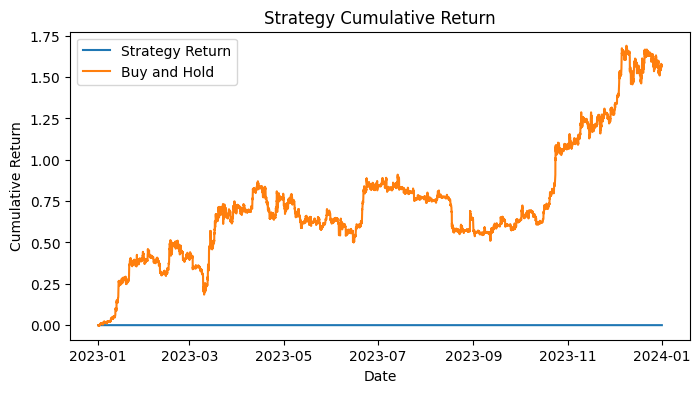

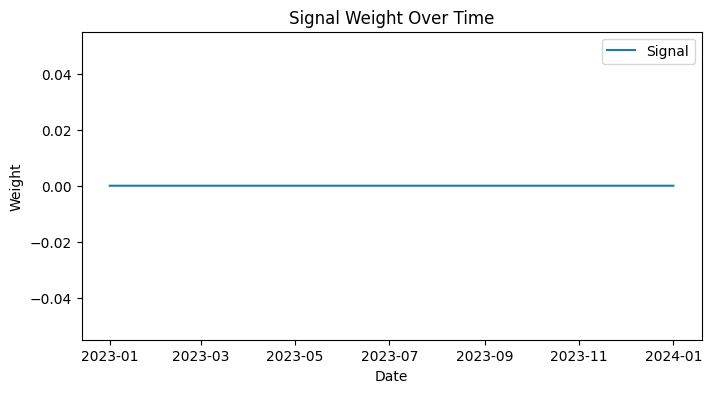

In [ ]:
temp = pd.DataFrame()
temp["date_hour"] = validation_data["date_hour"]
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x >= 1 else (-1 if x <= -1 else 0))

rfr_bt = temp
rfr_bt['date'] = pd.to_datetime(rfr_bt['date_hour'])

rfr_bt.set_index('date', inplace=True)


run_backtest(rfr_bt)




# XGB

In [ ]:
from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train_xgb = le.fit_transform(y_train)
# y_val = le.fit_transform(y_val)
# y_test = le.fit_transform(y_test)


xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_smoothed, y_train)
#Evaluate Model by Validation
y_pred_val = xgb.predict(X_val_smoothed)

mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')

Validation Set Metrics:
MSE: 0.000029
R-squared: -0.3888


In [ ]:
from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)


param_grid = {
    'n_estimators': [100,200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

xgb = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=1  # Use all available CPU cores
)
grid_search.fit(X_train_smoothed, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)
best_xgb_reg = grid_search.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 100}
Best Score (Negative MSE): -6.730520244918938e-05


Overall Annual Return: 96.65%
Overall Annual Sharpe Ratio: 1.836
Maximum Drawdown: -22.41 %
Alpha: 1.1129
Beta: 0.0138

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.966505    0.415231     0.013763        0.7481       1.835951


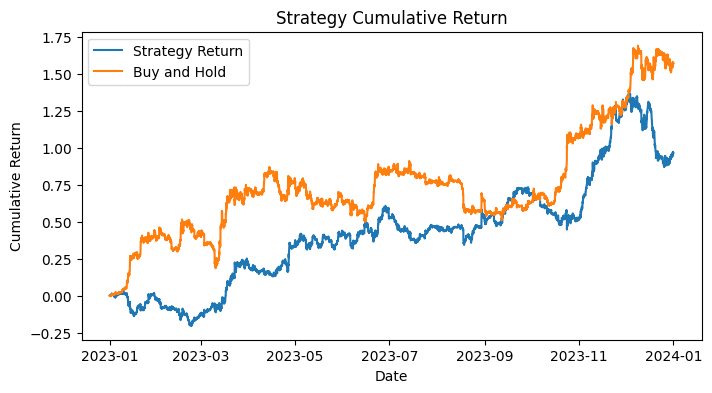

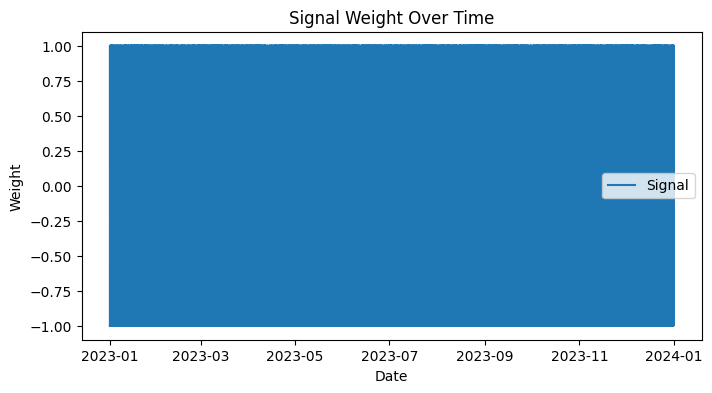

In [ ]:
temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
x['date'] = validation_data["date_hour"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt = temp


xgb_bt.set_index('date', inplace=True)


run_backtest(xgb_bt)



In [ ]:
importances = best_xgb_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


                Feature  Importance
11   Sentiment_24HR_ewm    0.230612
5        Sentiment_24HR    0.155525
6    tanalysis_absa_ewm    0.088502
8   regulation_absa_ewm    0.084497
3         Sentiment_6HR    0.076728
0        tanalysis_absa    0.075802
7      economy_absa_ewm    0.074870
2       regulation_absa    0.061591
9     Sentiment_6HR_ewm    0.056131
4        Sentiment_12HR    0.054742
1          economy_absa    0.041001
10   Sentiment_12HR_ewm    0.000000


# RFR Test

In [ ]:
X_test

,tanalysis_absa,economy_absa,regulation_absa,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR
17510,0.334815,0.121852,-0.005185,0.100000,0.095000,0.070833
17511,0.000000,-0.150000,0.350000,0.091667,0.101667,0.050417
17512,0.000000,0.000000,0.000000,0.056667,0.078333,0.046667
17513,0.111605,-0.009383,0.114938,0.056667,0.078333,0.046667
17514,0.700000,0.000000,0.000000,0.080000,0.070000,0.055000
...,...,...,...,...,...,...
35049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
model = best_rf_reg

X_test_smoothed = X_test.copy()
numeric_columns = X_test_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_test_smoothed[f'{col}_ewm'] = X_test_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_test = model.predict(X_test_smoothed)


temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
x['date'] = test_data["date_hour"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
x['signal'] = temp['signal']
y_pred_test

array([-0.00010745, -0.00013316, -0.00013969, ..., -0.00015471,
       -0.00015471, -0.00015471])

In [ ]:
signal_counts = x['signal'].value_counts()
print(signal_counts)



signal
 1    9327
-1    6311
 0    1906
Name: count, dtype: int64


Overall Annual Return: 8.73%
Overall Annual Sharpe Ratio: 0.4116
Maximum Drawdown: -45.2 %
Alpha: 0.0316
Beta: 0.1592

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.329433    0.397007     0.185252      0.171898       0.915941
1  2024      -0.110231    0.507715     0.142382     -0.120522       0.023674


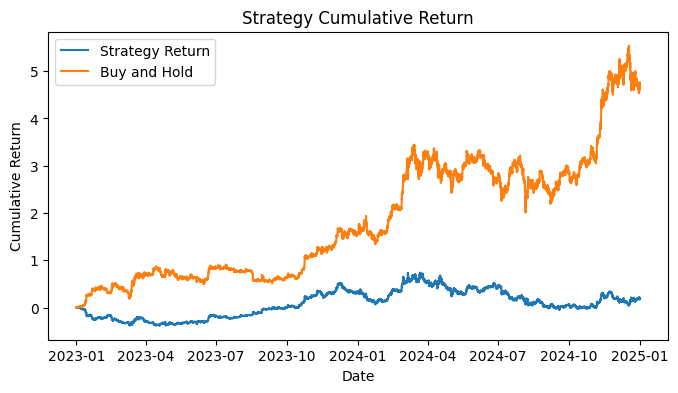

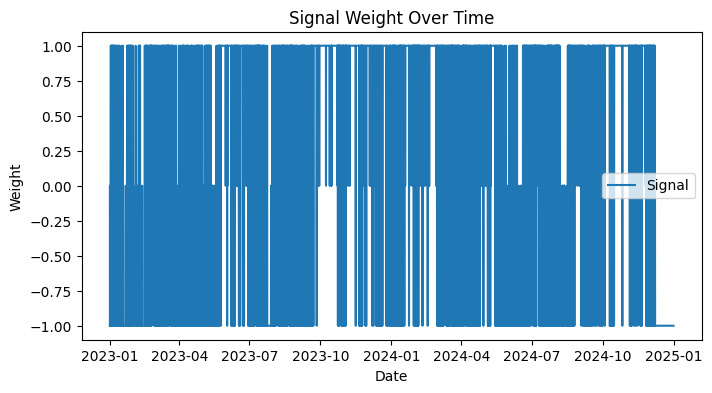

In [ ]:
temp['date'] = x['date']

rfr_bt_test = temp

rfr_bt_test.set_index('date', inplace=True)


run_backtest(rfr_bt_test)
rfr_result = test_data
rfr_result["signal"] = temp["signal"]
rfr_result.to_parquet('/workspaces/fyp/crypto_news/data/8.rfr_result.parquet')  


In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 0.000028
R-squared: -0.0850


# XGB TEST

In [ ]:
model = best_xgb_reg
y_pred_test = model.predict(X_test_smoothed)



temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
x['date'] = test_data["date_hour"]
x['date'] = pd.to_datetime(x['date'])

y_pred_test


array([-6.336198e-05, -8.262872e-05, -1.674897e-04, ..., -1.674897e-04,
       -1.674897e-04, -1.674897e-04], dtype=float32)

In [ ]:
temp["signal"]

0        0
1        0
2       -1
3       -1
4        0
        ..
17539   -1
17540   -1
17541   -1
17542   -1
17543   -1
Name: signal, Length: 17544, dtype: int64

Overall Annual Return: 46.32%
Overall Annual Sharpe Ratio: 1.1444
Maximum Drawdown: -42.75 %
Alpha: 0.2622
Beta: 0.2332

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       1.435524    0.323784     0.286156      0.646382       2.911064
1  2024      -0.119709    0.470126     0.198908     -0.202237      -0.036322


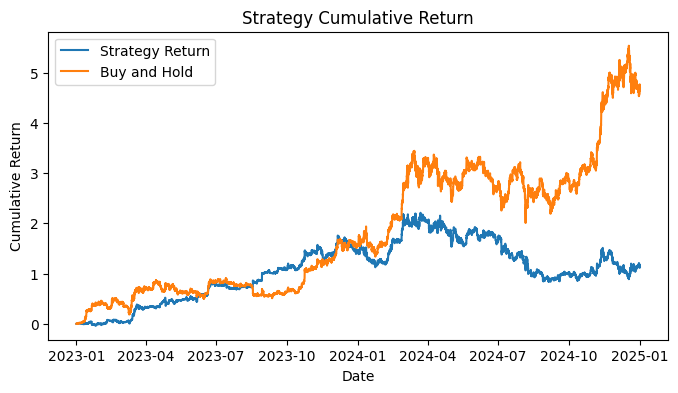

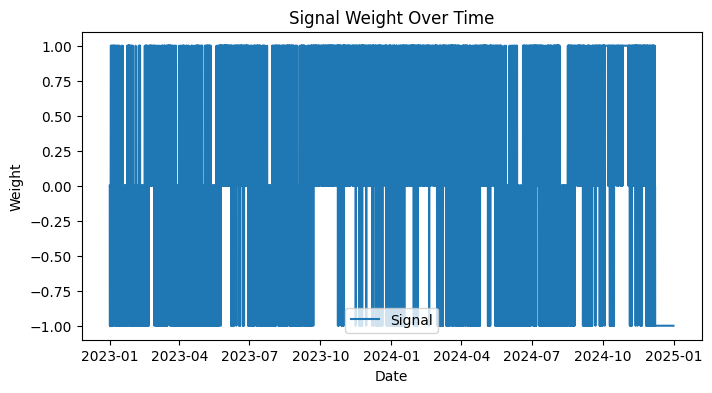

In [ ]:
x = x.reset_index(drop=True)
temp['date'] = x['date']
xgb_bt_test = temp
xgb_result = test_data
xgb_result = xgb_result.reset_index()


xgb_result["signal"] = temp["signal"]
xgb_result.to_parquet('/workspaces/fyp/crypto_news/data/8.xgb_result.parquet')  
xgb_bt_test.set_index('date', inplace=True)
run_backtest(xgb_bt_test)


In [ ]:
xgb_result

,index,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
0,17510,2023-01-01 00:00:00,0.334815,0.121852,-0.005185,0.014815,0.033704,0.0,0.28,0.100000,0.095000,0.070833,-0.00012076565424793189,0
1,17511,2023-01-01 01:00:00,0.000000,-0.150000,0.350000,0.000000,0.500000,2.0,0.14,0.091667,0.101667,0.050417,-0.00096624192282142641,0
2,17512,2023-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00,0.056667,0.078333,0.046667,-0.00211569848274194523,-1
3,17513,2023-01-01 03:00:00,0.111605,-0.009383,0.114938,0.004938,0.177901,0.0,0.00,0.056667,0.078333,0.046667,0.00121153380179307000,-1
4,17514,2023-01-01 04:00:00,0.700000,0.000000,0.000000,0.000000,0.000000,1.0,0.14,0.080000,0.070000,0.055000,-0.00042352371732817038,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,35049,2024-12-31 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,-0.00630797378946472641,-1
17540,35050,2024-12-31 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,0.00285821334903388110,-1
17541,35051,2024-12-31 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.00,0.000000,0.000000,0.000000,-0.00414167075852351572,-1
17542,35052,2024-12-31 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.00,0.000000,0.000000,0.000000,0.00093253585439578110,-1


In [ ]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Test Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Test Set Metrics:
MSE: 0.000026
R-squared: -0.0008
